# Deep Convolution Generative Adversarial Networks (DC-GANs) Demo

Implementation of DC-GAN trained to generate images from MNIST dataset

## Preliminaries — What is a GAN?

A **GAN** has two neural networks playing a game:
- **Generator (G)**: takes random noise `z` and tries to produce *realistic* images.
- **Discriminator (D)**: looks at images and predicts whether they are **real** (from dataset) or **fake** (from G).

They train **together**:
- D learns to distinguish real vs fake correctly.
- G learns to fool D so that D outputs "real" for G's images.

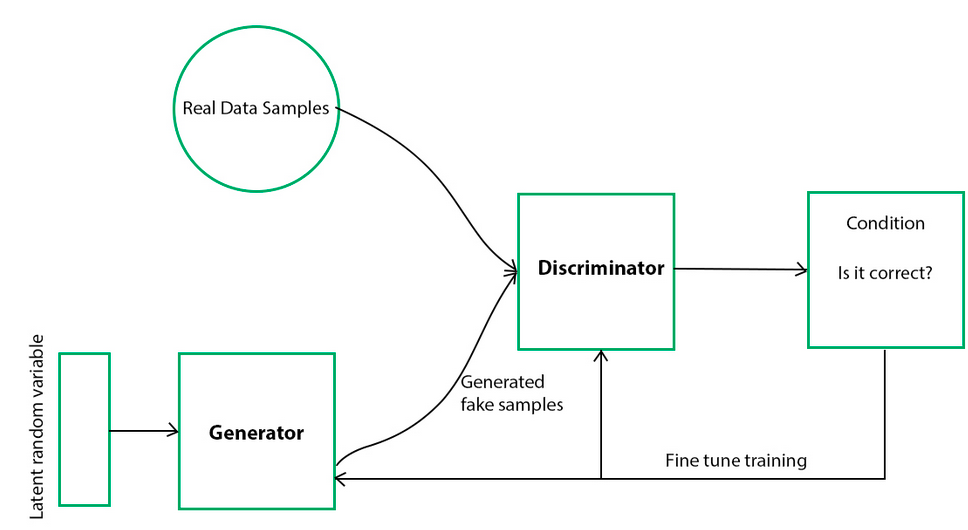


image_reference: https://evbn.org/generative-adversarial-network-gan-geeksforgeeks-1677899268/

### Why DCGAN?
**DCGAN** (Deep Convolutional GAN) is a CNN-based GAN that works very well for images:
- G uses **ConvTranspose** layers to *upscale* noise into images.
- D uses **Conv** layers to *downscale* images into a single logit (realness score).
- We use **BatchNorm** for stable gradients, **LeakyReLU** in D, **ReLU** in G, and **Tanh** at G's output.

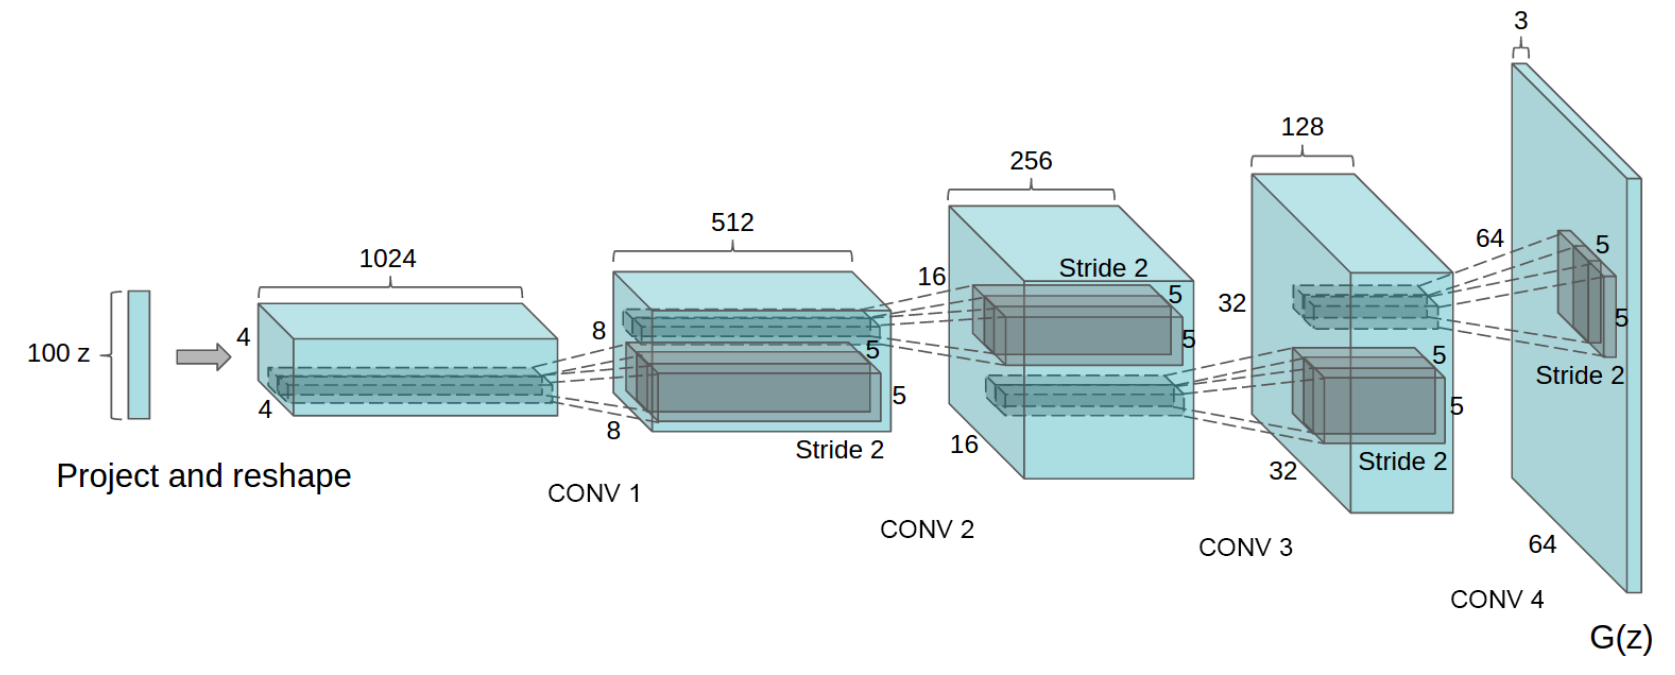

Reference: https://arxiv.org/pdf/1511.06434

### Losses (intuitive)
- **Discriminator loss**:  
  `L_D = BCE(D(real), 1) + BCE(D(fake), 0)`  
  (be good at telling real from fake)
- **Generator loss**:  
  `L_G = BCE(D(fake), 1)`  
  (make D think fakes are real)

We use **`BCEWithLogitsLoss`**, which expects *logits* (no Sigmoid layer in D) and is numerically stable.

## Required imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import random

## Config
All hyperparameters in one place, easy to adjust and experiment

In [2]:
class Config:
    #Data Parameters
    data_root = './data'
    batch_size = 128
    num_workers = 2

    #Model Parameters
    nc = 1          # num_channels
    ngf = 64        # generator feature maps
    ndf = 64        # discriminator feature maps
    z_dim = 100     # latent vector size (size of generator input)

    #Training Parameters
    max_epochs = 50
    lr = 2e-4
    lr_step = 20            # StepLR: shrink LR every lr_step epochs
    lr_gamma = 0.5          # factor to multiply LR at each step
    sample_every = 5        # visualize generator outputs every N epochs
    betas = (0.5, 0.999)

    seed = 42
    show_plots = True

## Utilities



In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


### Why normalization to `[-1, 1]`?
The Generator ends with **`Tanh`**, which outputs values in `[-1, 1]`.  
If the real data is normalized to the same range, G's job becomes much easier.

### Dataloader choices
- `shuffle=True` for training.
- `drop_last=True` in training for consistent batch sizes (helps BatchNorm).
- `pin_memory=True` on CUDA speeds up host to device transfers.

In [4]:
def get_dataloaders(cfg, device):
    """
    Returns train/val loaders. MNIST normalized to [-1, 1] to match Tanh generator output.
    """
    transform = T.Compose([
        T.ToTensor(),                                     # [0,1]
        T.Normalize((0.5,), (0.5,))                       # shift/scale to [-1, 1]
    ])

    train_ds = torchvision.datasets.MNIST(
        cfg.data_root, train=True, download=True, transform=transform
    )
    val_ds = torchvision.datasets.MNIST(
        cfg.data_root, train=False, download=True, transform=transform
    )

    pin = (device.type == "cuda")
    # drop_last keeps BN statistics stable and batch shapes consistent
    persistent = cfg.num_workers > 0

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=cfg.batch_size, shuffle=True,
        num_workers=cfg.num_workers, pin_memory=pin,
        drop_last=True, persistent_workers=persistent
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=pin,
        drop_last=False, persistent_workers=persistent
    )

    print('Loaded MNIST Dataset')
    print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")
    return train_loader, val_loader

In [5]:
def imshow(imgs, title=None, nrow=8, value_range=(-1, 1)):
    """
    Display a grid of images. Works for 1- or 3-channel images. Automatically normalizes for viewing.
    """
    grid = torchvision.utils.make_grid(imgs, nrow=nrow, normalize=True, value_range=value_range)
    npimg = grid.detach().cpu().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # (H, W, C)

    plt.figure(figsize=(8, 8))
    if npimg.shape[2] == 1:
        plt.imshow(npimg.squeeze(-1), cmap="gray")
    else:
        plt.imshow(npimg)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()



def save_grid(tensor, fname, nrow = 8, value_range=(-1,1)):
    """
    Save a grid of images to disk
    """
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, value_range=value_range)
    ndarr = (grid.detach().cpu().numpy().transpose(1,2,0) * 255)
    ndarr = ndarr.clip(0,255).astype(np.uint8)
    #if grayscale
    if ndarr.shape[2] == 1:
        plt.imsave(fname, ndarr.squeeze(-1), cmap="gray")
    else:
        plt.imsave(fname, ndarr)

def targets(size, device):
    return torch.ones(size, device=device), torch.zeros(size, device=device)        #real, fake

## Models
###  Model Architectures — DCGAN Generator & Discriminator

**Generator (G)**
- Input: noise `z` of shape `(N, z_dim, 1, 1)`.
- Uses **ConvTranspose2d** to "inflate" 1×1 into 7×7, then 14×14, then 28×28.
- Ends with a **3×3 Conv** to reach `nc` channels and **`Tanh`** to output in `[-1, 1]`.

**Discriminator (D)**
- Input: image `(N, nc, 28, 28)`.
- Downsamples 28→14→7 with **Conv** layers.
- Final **7×7 Conv** reduces to `(N, 1, 1, 1)` → we `view(-1)` to `(N,)` logits.

> **Important:** We **do not** put a `Sigmoid` at the end of D because we use  
> `BCEWithLogitsLoss`, which expects raw logits and handles the sigmoid internally.


In [6]:
class DC_generator(nn.Module):
    """
    z(N, z_dim, 1, 1) -> (ngf*4,7,7) -> (ngf*2,14,14) -> (ngf,28,28) -> (nc,28,28)
    """
    def __init__(self, z_dim=100, ngf=64, nc=1):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*4, kernel_size=7, stride=1, padding=0, bias=False),  # 1x1 -> 7x7
            nn.BatchNorm2d(ngf*4),  # stabilize distribution through training
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False), # 7x7 -> 14x14
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),   # 14x14 -> 28x28
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, nc, kernel_size=3, stride=1, padding=1, bias=False),               # 28x28 (reduce channels)
            nn.Tanh()
        )
    def forward(self, z):
        return self.gen(z)

In [7]:
class DC_discriminator(nn.Module):
    """
    x(N,nc,28,28) -> (ndf,14,14) -> (ndf*2,7,7) -> (1,1,1) -> logits
    """
    def __init__(self, nc=1, ndf=64):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),    #28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False), #14x14 -> 7x7
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, 1, kernel_size=7, stride=1, padding=0, bias=False),    #7x7 -> 1x1
            # No activation: BCEWithLogitsLoss expects raw logits
        )
    def forward(self, x):
        return self.dis(x).view(-1)  # (N,)

### Training
 Losses:
 - Discriminator: `L_D = BCE(D(real), 1) + BCE(D(fake), 0)`
 - Generator:     `L_G = BCE(D(fake), 1)` (tries to fool `D`)


In [8]:
def train_gan(cfg, DC_G, DC_D):
    #reproducibility
    set_seed(cfg.seed)
    device = get_device()
    print("Device:", device)

    #data
    train_loader, val_loader = get_dataloaders(cfg, device)
    print("Dataloader ready")

    #instantiate models
    G = DC_G(cfg.z_dim, cfg.ngf, cfg.nc).to(device)
    D = DC_D(cfg.nc, cfg.ndf).to(device)
    print("Model Loaded")
    print(G)
    print(D)

    #loss function
    criterion = nn.BCEWithLogitsLoss()
    #optimizers
    gen_opt  = torch.optim.Adam(G.parameters(), lr=cfg.lr, betas=cfg.betas)
    dis_opt  = torch.optim.Adam(D.parameters(), lr=cfg.lr, betas=cfg.betas)

    #learning rate schedulers
    G_scheduler  = StepLR(gen_opt, step_size=cfg.lr_step, gamma=cfg.lr_gamma)
    D_scheduler  = StepLR(dis_opt , step_size=cfg.lr_step, gamma=cfg.lr_gamma)

    #fixed noise for periodic visualization to track progress
    fixed_noise = torch.randn(64, cfg.z_dim, 1, 1, device=device)

    G_losses, D_losses = [], []
    val_G_losses, val_D_losses = [], []
    img_list = []

    # Preview a batch (sanity check)
    xb, yb = next(iter(train_loader))
    print("One training batch:", xb.shape, yb.shape, "range:", (xb.min().item(), xb.max().item()))

    #MAIN Training loop
    for epoch in range(1, cfg.max_epochs + 1):
        G.train(); D.train()
        G_loss_epoch = 0.0
        D_loss_epoch = 0.0

        for real_imgs, _ in train_loader:
            real_imgs = real_imgs.to(device)
            b = real_imgs.size(0)           #batch size
            real_tgt, fake_tgt = targets(b, device) # 1s for real, 0s for fake



            # Train Discriminator
            dis_opt.zero_grad(set_to_none=True)
            # sample noise
            z = torch.randn(b, cfg.z_dim, 1, 1, device=device)

            with torch.no_grad():
                fake_imgs = G(z)  # generating fake

            D_real  = D(real_imgs)
            D_fake  = D(fake_imgs)

            D_loss = criterion(D_real, real_tgt) + criterion(D_fake, fake_tgt)  #combined loss
            D_loss.backward()
            dis_opt.step()



            #Train Generator
            z = torch.randn(b, cfg.z_dim, 1, 1, device=device)  # resample noise for G step
            gen_opt.zero_grad()

            fake_imgs = G(z)    #generate fake
            D_fake_for_G = D(fake_imgs)

            G_loss = criterion(D_fake_for_G, real_tgt)  # want D to say "real"
            G_loss.backward()
            gen_opt.step()

            #batch losses
            G_loss_epoch += G_loss.item()
            D_loss_epoch += D_loss.item()

        # Epoch end
        G_losses.append(G_loss_epoch / len(train_loader))
        D_losses.append(D_loss_epoch / len(train_loader))

        #Validation
        G.eval(); D.eval()
        with torch.inference_mode():
            vg, vd = 0.0, 0.0
            for vimgs, _ in val_loader:
                vimgs = vimgs.to(device)
                b = vimgs.size(0)
                real_tgt, fake_tgt = targets(b, device)

                #D on real
                v_d_real = D(vimgs)
                v_loss_real = criterion(v_d_real, real_tgt)

                #D on fake
                vz = torch.randn(b, cfg.z_dim, 1, 1, device=device)
                v_fake = G(vz)
                v_d_fake = D(v_fake)
                v_loss_fake = criterion(v_d_fake, fake_tgt)

                vd += (v_loss_real + v_loss_fake).item()
                vg += criterion(v_d_fake, real_tgt).item()

            val_D_losses.append(vd / len(val_loader))
            val_G_losses.append(vg / len(val_loader))

        #Sampling
        if epoch % cfg.sample_every == 0 or epoch == 1:
            with torch.inference_mode():
                samples = G(fixed_noise)
            if cfg.show_plots:
                imshow(samples, title=f"Epoch {epoch}")

            img_list.append(torchvision.utils.make_grid(samples, nrow=8, normalize=True, value_range=(-1,1)).cpu())

        #step LR schedulers
        D_scheduler.step(); G_scheduler.step()

        #epoch summary
        print(f"Epoch {epoch:03d} | "
              f"G: {G_losses[-1]:.4f} | D: {D_losses[-1]:.4f} | "
              f"ValG: {val_G_losses[-1]:.4f} | ValD: {val_D_losses[-1]:.4f} | "
              f"LR(G/D): {gen_opt.param_groups[0]['lr']:.6f}/{dis_opt.param_groups[0]['lr']:.6f}")



    # Final plots
    if cfg.show_plots:
        epochs = np.arange(1, len(G_losses) + 1)
        plt.figure(figsize=(7,4))
        plt.plot(epochs, G_losses, label="Train G")
        plt.plot(epochs, val_G_losses, label="Val G")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Generator Loss"); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7,4))
        plt.plot(epochs, D_losses, label="Train D")
        plt.plot(epochs, val_D_losses, label="Val D")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Discriminator Loss"); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7,4))
        plt.plot(epochs, G_losses, label="Train G")
        plt.plot(epochs, D_losses, label="Train D")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Generator vs Discriminator Loss"); plt.legend(); plt.tight_layout(); plt.show()

    # final model save
    torch.save(G.state_dict(), "dcgan_mnist_G.pth")
    torch.save(D.state_dict(), "dcgan_mnist_D.pth")
    print("Saved generator/discriminator state_dicts.")
    return G_losses, D_losses, val_G_losses, val_D_losses, img_list

##  Qualitative Evaluation — Fake vs Nearest Real (Cosine Similarity)

**Why this check?**  
It's a quick sanity check to ensure the generator isn't just producing nonsense (or pixel-perfect copies).  
We:
1. Generate a batch of fake images.
2. Collect a small pool of real images.
3. Flatten and L2-normalize them.
4. Compute cosine similarity (`fake @ real^T`).
5. For each fake, find the nearest real image and visualize pairs.

> **Note:** This is *not* a formal metric like FID/KID, but it's helpful for visualization.


In [9]:
def show_fake_vs_nearest_real(G, val_loader, z_dim, device,
    n_gen = 32, n_real = 64, n_show = 16
):
    """
    Quick sanity check: generate a few samples, find nearest real MNIST images in pixel-space cosine.
    """
    G.eval()
    with torch.inference_mode():
        z = torch.randn(n_gen, z_dim, 1, 1, device=device)
        fake = G(z)  # (n_gen, 1, 28, 28)

    # accumulate a small pool of real images
    real_batches = []
    seen = 0
    for x, _ in val_loader:
        real_batches.append(x)
        seen += x.size(0)
        if seen >= n_real:
            break

    # Stack to (n_real, nc, 28, 28) and move to device
    real = torch.cat(real_batches, 0)[:n_real].to(device)

    # Compute cosine similarity between flattened, L2-normalized vectors
    with torch.inference_mode():
        fake_flat = F.normalize(fake.view(n_gen, -1), p=2, dim=1)   # (n_gen, 784)
        real_flat = F.normalize(real.view(n_real, -1), p=2, dim=1)  # (n_real, 784)
        sim = fake_flat @ real_flat.t()                             # (n_gen, n_real) cosine similarities
        best_sim, best_idx = sim.max(dim=1)                         # best match per fake

    print(f"Average best cosine similarity: {best_sim.mean().item():.4f}")
    topk = best_sim.topk(min(5, best_sim.numel())).values.tolist()
    print("Top best similarities:", ", ".join(f"{v:.3f}" for v in topk))

    # Show generated samples
    grid_fake = torchvision.utils.make_grid(fake[:n_show].cpu(), nrow=8, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(6, 6)); plt.imshow(grid_fake.permute(1,2,0).numpy()); plt.axis("off"); plt.title("Generated samples"); plt.show()

    # Show nearest real samples
    nearest_real = real[best_idx[:n_show]].cpu()
    grid_real = torchvision.utils.make_grid(nearest_real, nrow=8, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(6, 6)); plt.imshow(grid_real.permute(1,2,0).numpy()); plt.axis("off"); plt.title("Nearest real samples (cosine)"); plt.show()

    # Side-by-side pairs
    pairs = []
    for i in range(min(8, n_show)):
        pairs.append(fake[i].cpu()); pairs.append(nearest_real[i])
    pair_grid = torchvision.utils.make_grid(pairs, nrow=2, normalize=True, value_range=(-1, 1), padding=2)
    plt.figure(figsize=(4, 16)); plt.imshow(pair_grid.permute(1,2,0).numpy()); plt.axis("off"); plt.title("Pairs: Fake | Nearest Real")
    plt.show()



### Train the model

Device: cuda
Loaded MNIST Dataset
Train samples: 60000 | Val samples: 10000
Dataloader ready
Model Loaded
DC_generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
DC_discriminator(
  (dis): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

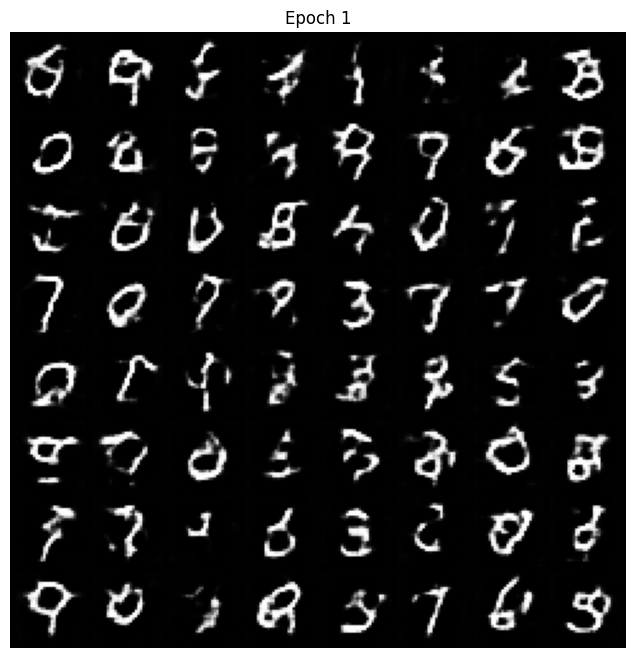

Epoch 001 | G: 1.0480 | D: 1.1235 | ValG: 1.2260 | ValD: 1.3418 | LR(G/D): 0.000200/0.000200
Epoch 002 | G: 0.9837 | D: 1.1418 | ValG: 1.3370 | ValD: 1.5379 | LR(G/D): 0.000200/0.000200
Epoch 003 | G: 0.9302 | D: 1.1995 | ValG: 0.8926 | ValD: 1.2616 | LR(G/D): 0.000200/0.000200
Epoch 004 | G: 0.9159 | D: 1.2302 | ValG: 1.1433 | ValD: 1.3151 | LR(G/D): 0.000200/0.000200


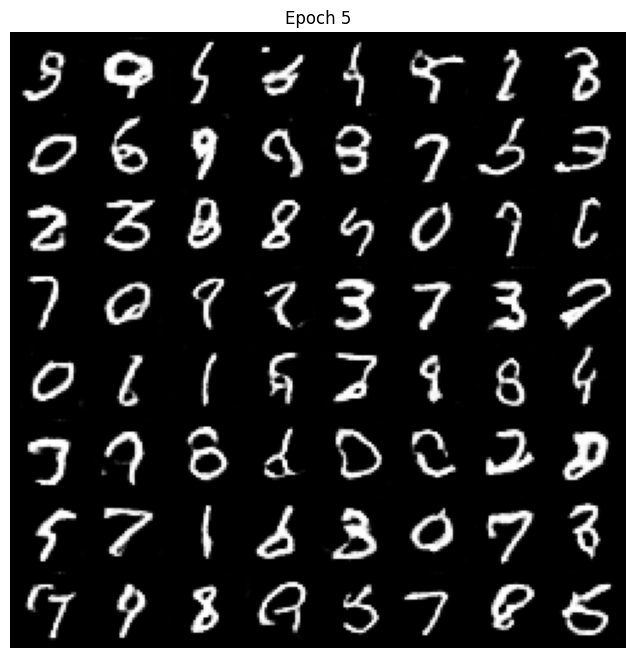

Epoch 005 | G: 0.8948 | D: 1.2527 | ValG: 0.7030 | ValD: 1.3371 | LR(G/D): 0.000200/0.000200
Epoch 006 | G: 0.8722 | D: 1.2728 | ValG: 0.7950 | ValD: 1.2832 | LR(G/D): 0.000200/0.000200
Epoch 007 | G: 0.8574 | D: 1.2874 | ValG: 0.6256 | ValD: 1.3446 | LR(G/D): 0.000200/0.000200
Epoch 008 | G: 0.8439 | D: 1.2935 | ValG: 1.0702 | ValD: 1.3748 | LR(G/D): 0.000200/0.000200
Epoch 009 | G: 0.8449 | D: 1.3037 | ValG: 0.9760 | ValD: 1.3078 | LR(G/D): 0.000200/0.000200


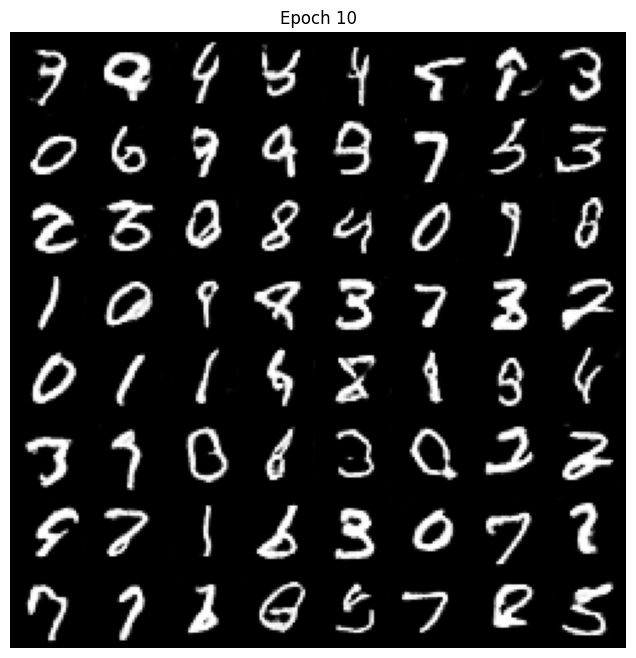

Epoch 010 | G: 0.8305 | D: 1.3102 | ValG: 0.6158 | ValD: 1.3690 | LR(G/D): 0.000200/0.000200
Epoch 011 | G: 0.8233 | D: 1.3107 | ValG: 0.7395 | ValD: 1.3389 | LR(G/D): 0.000200/0.000200
Epoch 012 | G: 0.8183 | D: 1.3197 | ValG: 0.5169 | ValD: 1.4214 | LR(G/D): 0.000200/0.000200
Epoch 013 | G: 0.8197 | D: 1.3210 | ValG: 0.7171 | ValD: 1.3595 | LR(G/D): 0.000200/0.000200
Epoch 014 | G: 0.8100 | D: 1.3248 | ValG: 0.8723 | ValD: 1.3630 | LR(G/D): 0.000200/0.000200


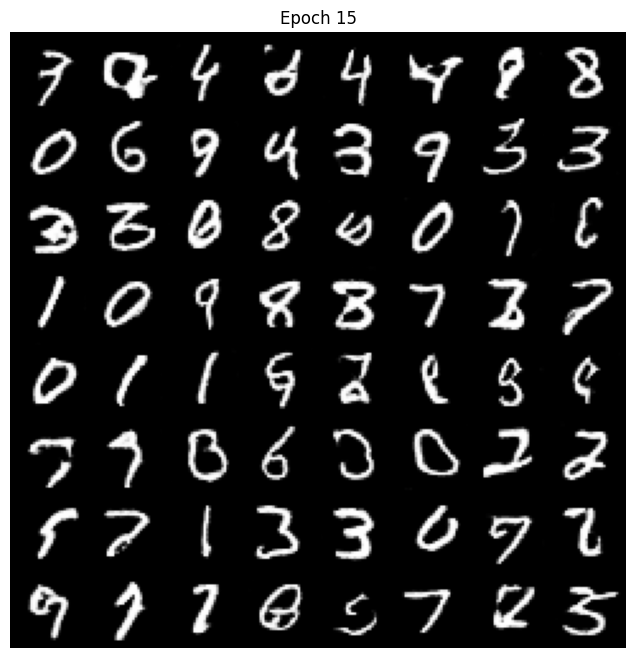

Epoch 015 | G: 0.8036 | D: 1.3305 | ValG: 0.5312 | ValD: 1.4128 | LR(G/D): 0.000200/0.000200
Epoch 016 | G: 0.8030 | D: 1.3323 | ValG: 0.6110 | ValD: 1.3930 | LR(G/D): 0.000200/0.000200
Epoch 017 | G: 0.8000 | D: 1.3348 | ValG: 0.8693 | ValD: 1.3711 | LR(G/D): 0.000200/0.000200
Epoch 018 | G: 0.7938 | D: 1.3386 | ValG: 0.9971 | ValD: 1.4027 | LR(G/D): 0.000200/0.000200
Epoch 019 | G: 0.7899 | D: 1.3407 | ValG: 0.6361 | ValD: 1.3929 | LR(G/D): 0.000200/0.000200


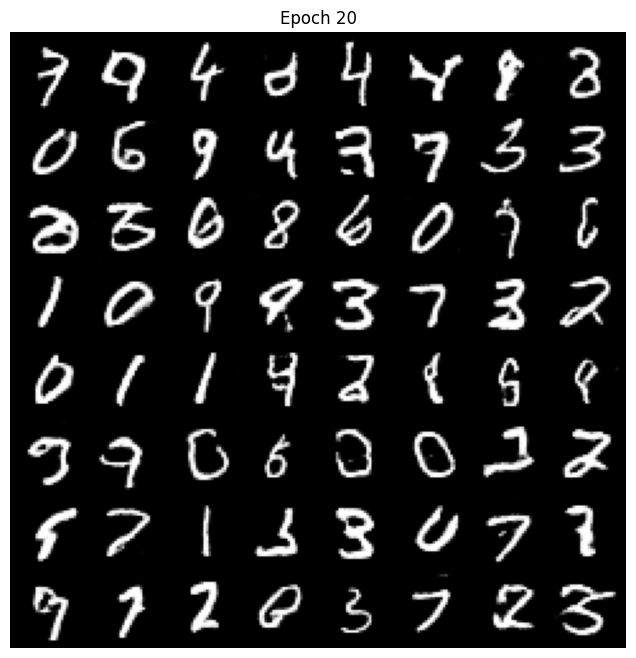

Epoch 020 | G: 0.7883 | D: 1.3440 | ValG: 0.8496 | ValD: 1.3674 | LR(G/D): 0.000100/0.000100
Epoch 021 | G: 0.7608 | D: 1.3235 | ValG: 0.7151 | ValD: 1.3679 | LR(G/D): 0.000100/0.000100
Epoch 022 | G: 0.7623 | D: 1.3290 | ValG: 0.8320 | ValD: 1.3816 | LR(G/D): 0.000100/0.000100
Epoch 023 | G: 0.7607 | D: 1.3331 | ValG: 0.6429 | ValD: 1.3775 | LR(G/D): 0.000100/0.000100
Epoch 024 | G: 0.7601 | D: 1.3361 | ValG: 0.7178 | ValD: 1.3638 | LR(G/D): 0.000100/0.000100


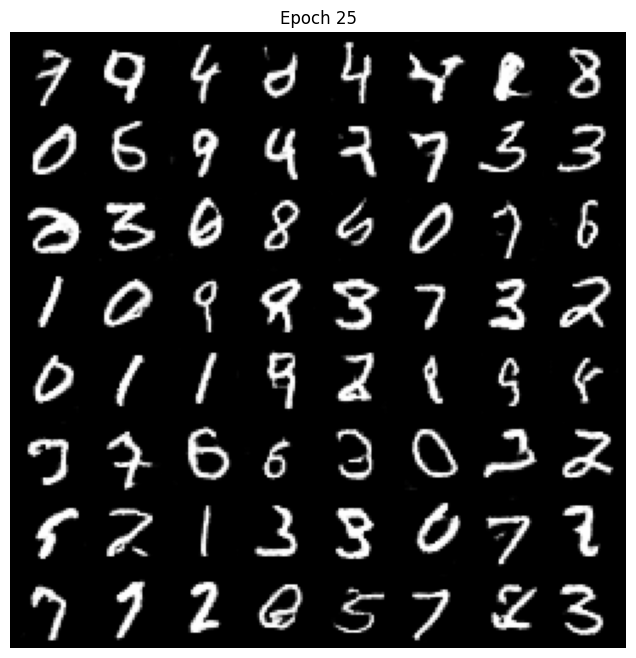

Epoch 025 | G: 0.7614 | D: 1.3402 | ValG: 0.6366 | ValD: 1.3819 | LR(G/D): 0.000100/0.000100
Epoch 026 | G: 0.7564 | D: 1.3423 | ValG: 0.7506 | ValD: 1.3857 | LR(G/D): 0.000100/0.000100
Epoch 027 | G: 0.7569 | D: 1.3423 | ValG: 0.8922 | ValD: 1.3721 | LR(G/D): 0.000100/0.000100
Epoch 028 | G: 0.7558 | D: 1.3449 | ValG: 0.8316 | ValD: 1.3966 | LR(G/D): 0.000100/0.000100
Epoch 029 | G: 0.7528 | D: 1.3465 | ValG: 0.8171 | ValD: 1.3755 | LR(G/D): 0.000100/0.000100


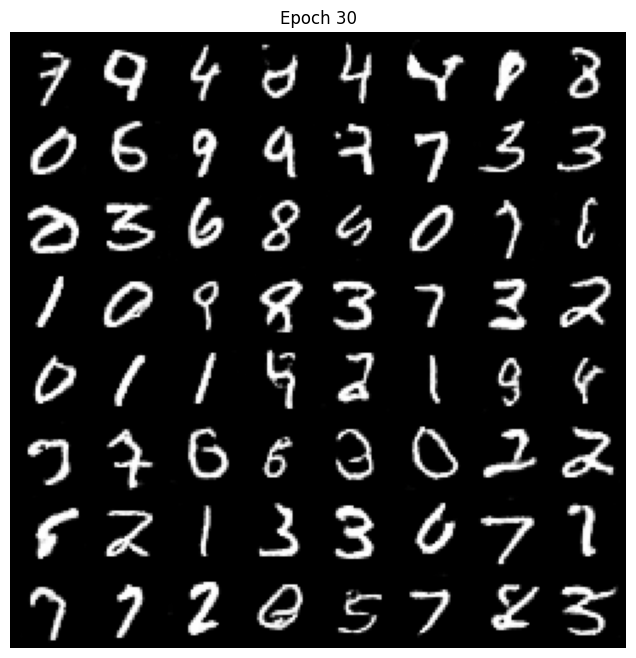

Epoch 030 | G: 0.7561 | D: 1.3468 | ValG: 0.6876 | ValD: 1.3743 | LR(G/D): 0.000100/0.000100
Epoch 031 | G: 0.7553 | D: 1.3471 | ValG: 0.5730 | ValD: 1.4108 | LR(G/D): 0.000100/0.000100
Epoch 032 | G: 0.7540 | D: 1.3482 | ValG: 0.8772 | ValD: 1.3932 | LR(G/D): 0.000100/0.000100
Epoch 033 | G: 0.7519 | D: 1.3487 | ValG: 0.7410 | ValD: 1.3806 | LR(G/D): 0.000100/0.000100
Epoch 034 | G: 0.7513 | D: 1.3488 | ValG: 0.8369 | ValD: 1.3883 | LR(G/D): 0.000100/0.000100


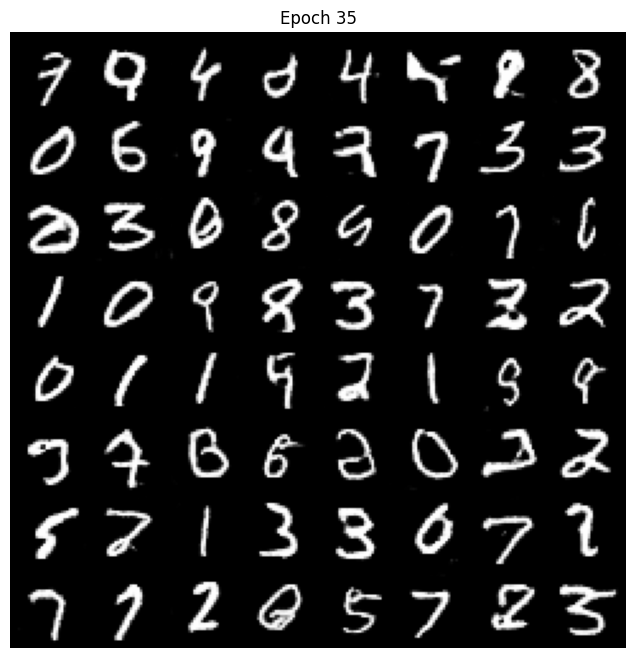

Epoch 035 | G: 0.7523 | D: 1.3508 | ValG: 0.7615 | ValD: 1.3791 | LR(G/D): 0.000100/0.000100
Epoch 036 | G: 0.7511 | D: 1.3507 | ValG: 0.7054 | ValD: 1.3872 | LR(G/D): 0.000100/0.000100
Epoch 037 | G: 0.7504 | D: 1.3512 | ValG: 0.6972 | ValD: 1.3831 | LR(G/D): 0.000100/0.000100
Epoch 038 | G: 0.7504 | D: 1.3520 | ValG: 0.7442 | ValD: 1.3647 | LR(G/D): 0.000100/0.000100
Epoch 039 | G: 0.7506 | D: 1.3532 | ValG: 0.8069 | ValD: 1.3878 | LR(G/D): 0.000100/0.000100


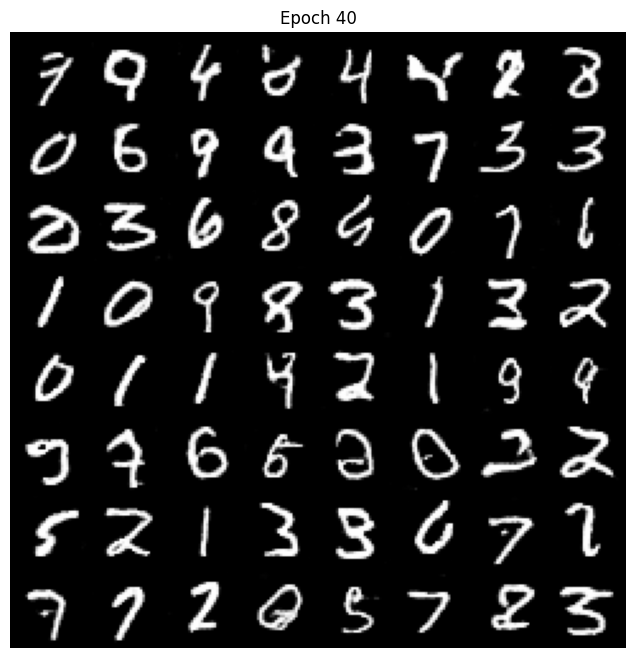

Epoch 040 | G: 0.7492 | D: 1.3547 | ValG: 0.7601 | ValD: 1.3766 | LR(G/D): 0.000050/0.000050
Epoch 041 | G: 0.7413 | D: 1.3422 | ValG: 0.7234 | ValD: 1.3822 | LR(G/D): 0.000050/0.000050
Epoch 042 | G: 0.7405 | D: 1.3453 | ValG: 0.6618 | ValD: 1.3870 | LR(G/D): 0.000050/0.000050
Epoch 043 | G: 0.7395 | D: 1.3448 | ValG: 0.8089 | ValD: 1.3811 | LR(G/D): 0.000050/0.000050
Epoch 044 | G: 0.7393 | D: 1.3464 | ValG: 0.8494 | ValD: 1.3999 | LR(G/D): 0.000050/0.000050


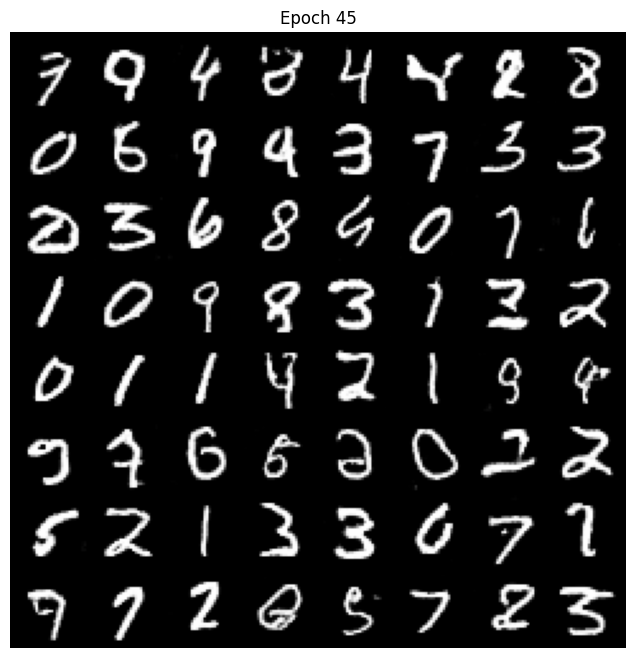

Epoch 045 | G: 0.7385 | D: 1.3482 | ValG: 0.6516 | ValD: 1.3864 | LR(G/D): 0.000050/0.000050
Epoch 046 | G: 0.7384 | D: 1.3495 | ValG: 0.6410 | ValD: 1.3881 | LR(G/D): 0.000050/0.000050
Epoch 047 | G: 0.7382 | D: 1.3485 | ValG: 0.7333 | ValD: 1.3784 | LR(G/D): 0.000050/0.000050
Epoch 048 | G: 0.7405 | D: 1.3511 | ValG: 0.8534 | ValD: 1.3998 | LR(G/D): 0.000050/0.000050
Epoch 049 | G: 0.7395 | D: 1.3518 | ValG: 0.7628 | ValD: 1.3831 | LR(G/D): 0.000050/0.000050


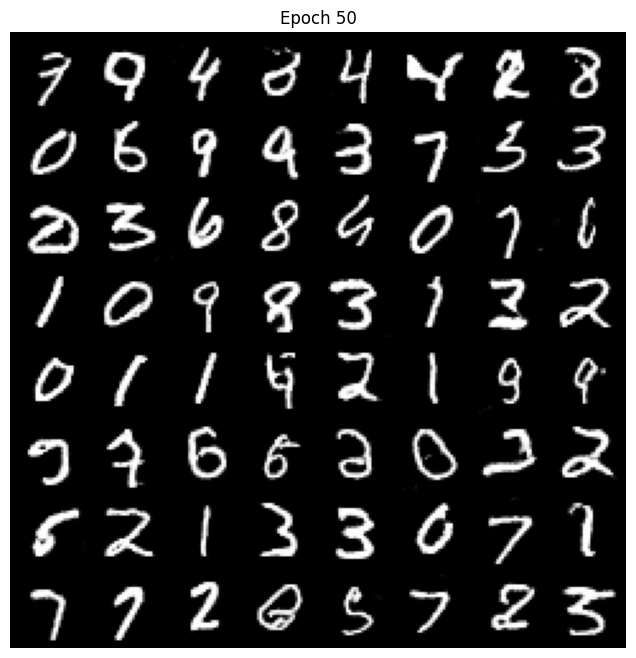

Epoch 050 | G: 0.7383 | D: 1.3512 | ValG: 0.6965 | ValD: 1.3849 | LR(G/D): 0.000050/0.000050


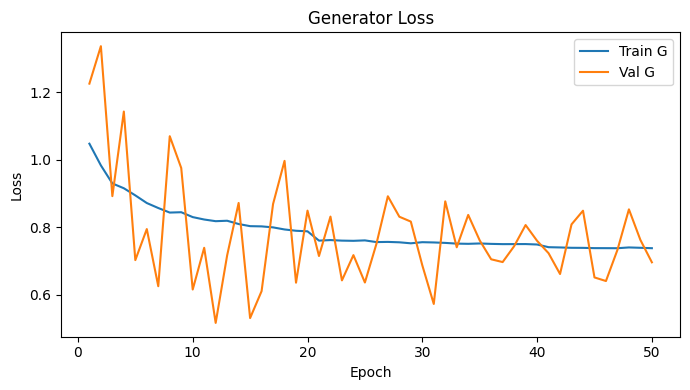

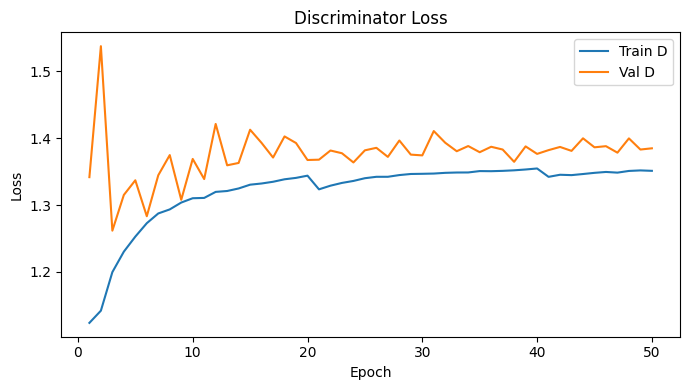

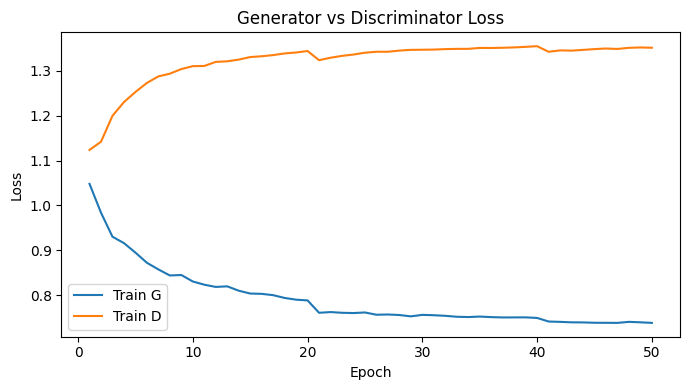

Saved generator/discriminator state_dicts.


In [10]:
cfg = Config()
G_losses, D_losses, val_G_losses, val_D_losses, img_list = train_gan(cfg, DC_generator, DC_discriminator)

### Visualizing and checking generated images
We now:
- rebuild the Generator architecture
- load saved weights
- generate samples and compare to nearest real images from the validation set

Loaded MNIST Dataset
Train samples: 60000 | Val samples: 10000
Average best cosine similarity: 0.8506
Top best similarities: 0.960, 0.952, 0.920, 0.916, 0.908


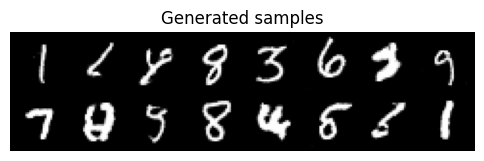

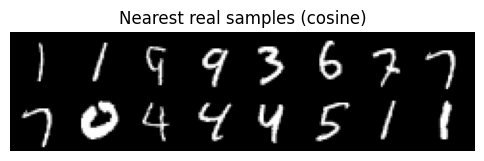

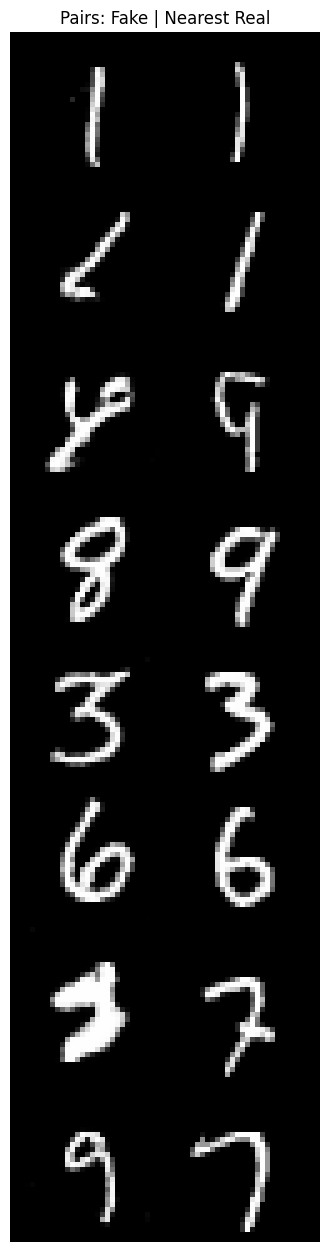

In [11]:
device = get_device()
_, val_loader = get_dataloaders(cfg, device)

G = DC_generator(cfg.z_dim, cfg.ngf, cfg.nc).to(device)
G.load_state_dict(torch.load("dcgan_mnist_G.pth", map_location=device))
show_fake_vs_nearest_real(G, val_loader, cfg.z_dim, device)

### Exercises
1. Switch `nc=3` and train on CIFAR-10 (change transforms & dataset).
2. Replace `StepLR` with `CosineAnnealingLR` — what happens to convergence?
3. Try different latent sizes (`z_dim=64` vs `z_dim=256`).
4. Add **label smoothing** (use `0.9` for real targets) and observe stability.
5. Visualize interpolations: sample `z1`, `z2`, then linearly interpolate between them through G.